# Data Wrangling

The purpose of this stage is to take the raw data from the S3 bucket and convert it into a dataset which can be used for building ML models. This stage also involves performing exploratory data analysis.

## Loading the data from S3 bucket

In [1]:
import boto3

In [2]:
s3 = boto3.resource(
    service_name='s3',
    use_ssl=False,
    aws_access_key_id='',
    aws_secret_access_key=''
)

In [3]:
obj = s3.Bucket('reco-data-lake').Object('Office_Products.json').get()['Body'].read()

In [4]:
data = obj.decode('UTF-8')

In [5]:
data_list = data[:300000000].split("\n")

In [6]:
# Collected Over 620,000 reviews
len(data_list)

620388

In [7]:
# Sample Review
data_list[0]

'{"overall": 3.0, "vote": "6", "verified": false, "reviewTime": "11 3, 2006", "reviewerID": "A2WJLOXXIB7NF3", "asin": "0140503528", "style": {"Format:": " Hardcover"}, "reviewerName": "Brandi D&#039;Angelo", "reviewText": "I thought the book was entertaining and cute, and an introduction to what goes on at a laundromat. However, I don\'t think I would get this book for a young todder (under 4) due to the fact that there was one scene where Corduroy is alone in the dark of laudromat, inside a wired laundry cart, and he looks terrified. The picture is very scary and sad. I think it\'s too much for a little kid. But overall, it\'s cute, and the ending is good.", "summary": "Entertaining-but maybe not for young toddlers", "unixReviewTime": 1162512000}'

## Converting the data into JSON

In [8]:
import json

In [9]:
data_json_list = []

for each in data_list[:-2]:
    data_json = json.loads(each)
    data_json_list.append(data_json)

In [10]:
# Still over 620,000 reviews in out data list
len(data_json_list)

620386

## Extracting the required details from data

In [22]:
required_data_json = []
required_data_tabular = [['userId', 'productId', 'rating']]
for review in data_json_list:
    required_data_map = {}
    required_data_map['rating'] = review['overall']
    required_data_map['userId'] = review['reviewerID']
    required_data_map['productId'] = review['asin']
    required_data_tabular += [[review['reviewerID'], review['asin'], review['overall']]]
    required_data_json.append(required_data_map)

In [20]:
# Ten values of the required data for training
required_data_json[0:10]

[{'rating': 3.0, 'userId': 'A2WJLOXXIB7NF3', 'productId': '0140503528'},
 {'rating': 5.0, 'userId': 'A1RKICUK0GG6VF', 'productId': '0140503528'},
 {'rating': 5.0, 'userId': 'A1QA5E50M398VW', 'productId': '0140503528'},
 {'rating': 5.0, 'userId': 'A3N0HBW8IP8CZQ', 'productId': '0140503528'},
 {'rating': 5.0, 'userId': 'A1K1JW1C5CUSUZ', 'productId': '0140503528'},
 {'rating': 5.0, 'userId': 'A3GIXT0M21V3JR', 'productId': '0140503528'},
 {'rating': 4.0, 'userId': 'A2NIJTYWADLK57', 'productId': '0140503528'},
 {'rating': 4.0, 'userId': 'A2PNBV0VHHSO2I', 'productId': '0140503528'},
 {'rating': 5.0, 'userId': 'AIYOHMZQ53DRL', 'productId': '0140503528'},
 {'rating': 5.0, 'userId': 'A6J32ICD0JCGJ', 'productId': '0140503528'}]

In [23]:
# Displaying the data in a table format
required_data_tabular[:10]

[['userId', 'productId', 'rating'],
 ['A2WJLOXXIB7NF3', '0140503528', 3.0],
 ['A1RKICUK0GG6VF', '0140503528', 5.0],
 ['A1QA5E50M398VW', '0140503528', 5.0],
 ['A3N0HBW8IP8CZQ', '0140503528', 5.0],
 ['A1K1JW1C5CUSUZ', '0140503528', 5.0],
 ['A3GIXT0M21V3JR', '0140503528', 5.0],
 ['A2NIJTYWADLK57', '0140503528', 4.0],
 ['A2PNBV0VHHSO2I', '0140503528', 4.0],
 ['AIYOHMZQ53DRL', '0140503528', 5.0]]

## EDA

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

In [25]:
# Converting the column to pandas dataframe
review_df = pd.DataFrame(required_data_tabular[1:], columns=required_data_tabular[0])

In [34]:
# Pandas dataframe
print(review_df.shape)
review_df

(620386, 3)


,userId,productId,rating
0,A2WJLOXXIB7NF3,0140503528,3.0
1,A1RKICUK0GG6VF,0140503528,5.0
2,A1QA5E50M398VW,0140503528,5.0
3,A3N0HBW8IP8CZQ,0140503528,5.0
4,A1K1JW1C5CUSUZ,0140503528,5.0
...,...,...,...
620381,A3B5ZNI6WWCPX1,B000A2BKAM,5.0
620382,A22LCJP70ZBX1K,B000A2BKAM,3.0
620383,ASIB7E9AVJCZS,B000A2BKAM,4.0
620384,A3PHPUBWQVOIK1,B000A2BKAM,1.0


In [31]:
# The number of unique users = 498k
# The number of unique products = 6197
review_df.nunique()

userId       498418
productId      6197
rating            5
dtype: int64

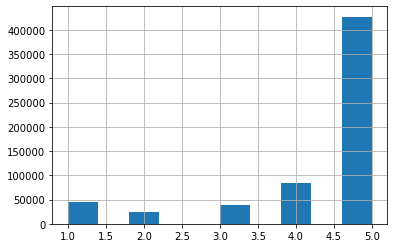

In [29]:
review_df['rating'].hist()

In [51]:
# Removing users who have rated just 1 product and given it a 5 rating
filtered_df = review_df[review_df['rating'] != 5 & review_df.userId.duplicated(keep=False)]

In [52]:
# Removing 0.4 users who have rated 5
filtered_df = filtered_df.drop(filtered_df.query('rating == 5').sample(frac=0.5).index)

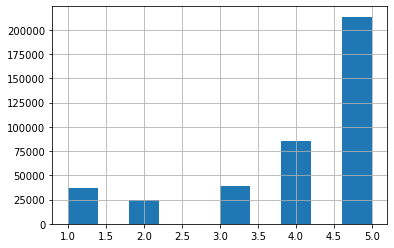

In [53]:
filtered_df['rating'].hist()

In [55]:
print(filtered_df.shape)
print(filtered_df.nunique())

(399427, 3)
userId       346660
productId      6023
rating            5
dtype: int64


In [57]:
# Checking for null values
filtered_df.isnull().sum()

userId       0
productId    0
rating       0
dtype: int64

In [56]:
filtered_df.to_csv('product_review_dataset.csv')